In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
from random import choice,shuffle
from scipy import stats as st
 
from collections import deque

In [4]:
def gather_data(num_samples):
     
    global rock, paper, scissor, nothing
     
    cap = cv2.VideoCapture(0)
 
    trigger = False
     
    counter = 0
     
    box_size = 234
     
    width = int(cap.get(3))
 
 
    while True:
         
        ret, frame = cap.read()
         
        frame = cv2.flip(frame, 1)
         
        if not ret:
            break
             
        if counter == num_samples:
            trigger = not trigger
            counter = 0
         
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
        cv2.namedWindow("Collecting images", cv2.WINDOW_NORMAL)
         
         
        if trigger:
             
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
             
            eval(class_name).append([roi, class_name])
                                     
            counter += 1
         
            text = "Collected Samples of {}: {}".format(class_name, counter)
             
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
         
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
         
        cv2.imshow("Collecting images", frame)
         
        k = cv2.waitKey(1)
         
        if k == ord('r'):
             
            trigger = not trigger
            class_name = 'rock'
            rock = []
            
             
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
         
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                     
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
         
        if k == ord('q'):
            break
             
    cap.release()
    cv2.destroyAllWindows()

In [5]:
no_of_samples = 100
gather_data(no_of_samples)

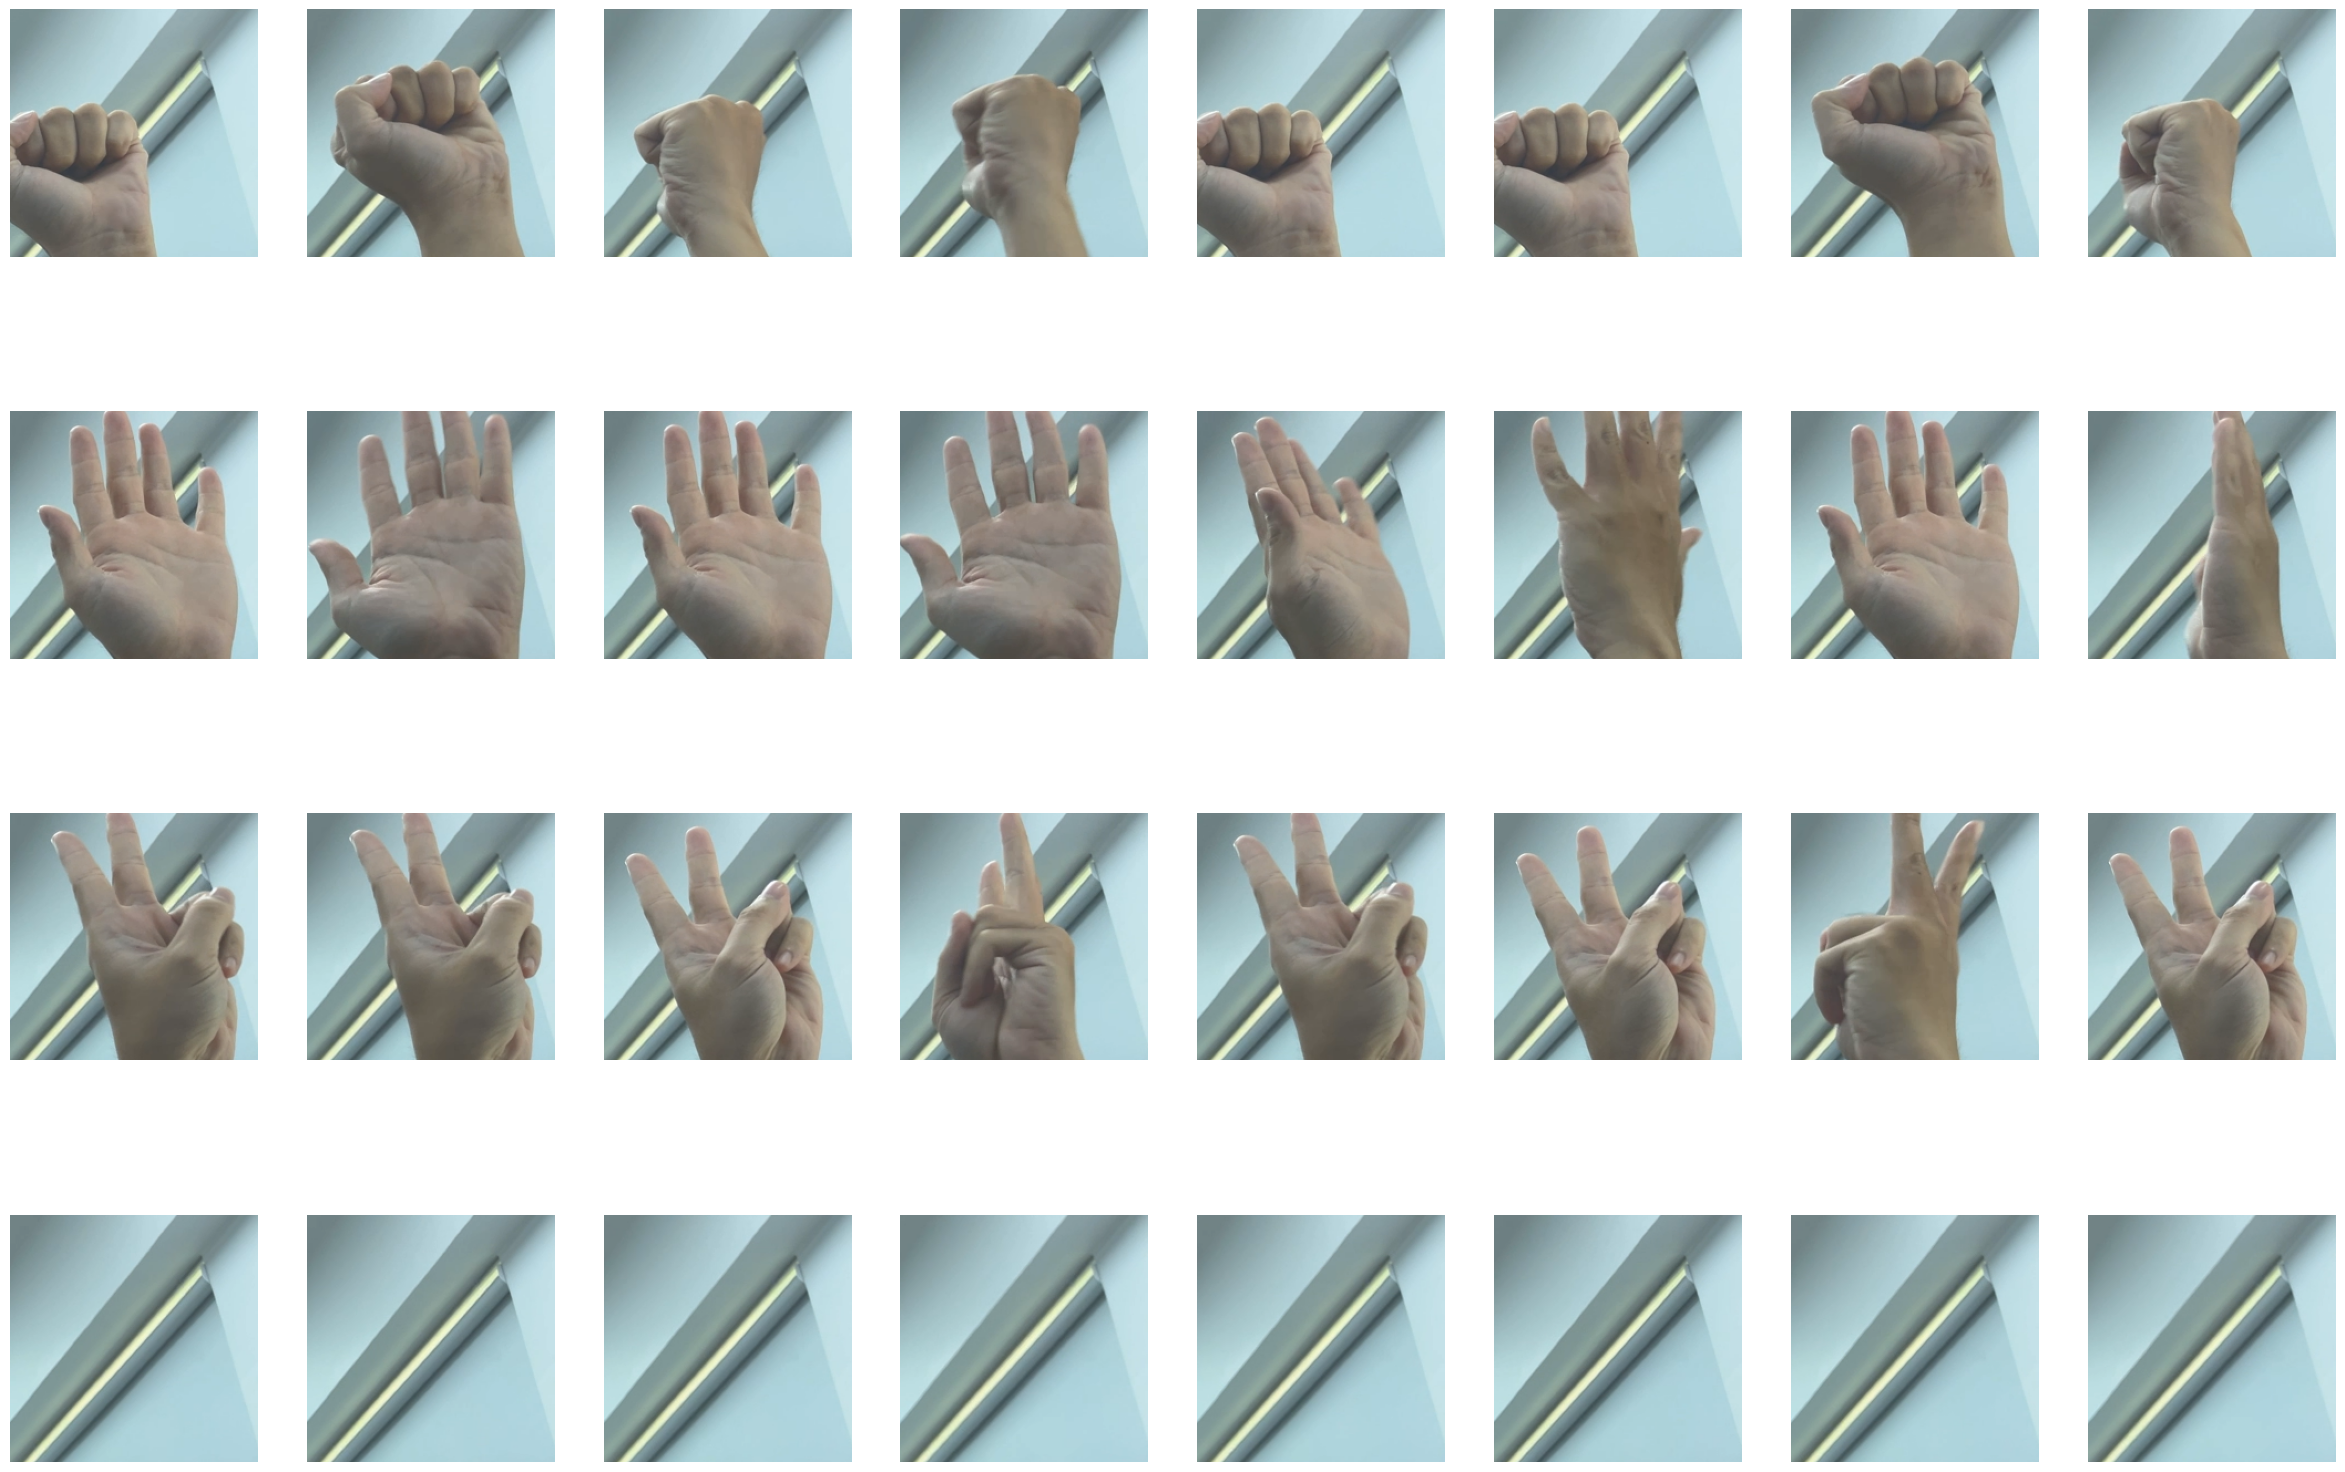

In [6]:
plt.figure(figsize=[30,20])
 
rows, cols = 4, 8
 
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
     
    r = np.random.randint(no_of_samples, size=8);
     
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');


In [7]:
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]
 
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]
 
images = np.array(images, dtype="float") / 255.0
 
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))
 
encoder = LabelEncoder()
 
Int_labels = encoder.fit_transform(labels)
 
one_hot_labels = to_categorical(Int_labels, 4)
 
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)
 
images = []
 

Total images: 400 , Total Labels: 400


In [8]:
image_size = 224
 
N_mobile = tf.keras.applications.NASNetMobile( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
 
N_mobile.trainable = False
     
x = N_mobile.output
 
x = GlobalAveragePooling2D()(x)
 
x = Dense(712, activation='relu')(x) 
 
x = Dropout(0.40)(x)
 
preds = Dense(4,activation='softmax')(x) 
 
model = Model(inputs=N_mobile.input, outputs=preds)
 
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 773


In [9]:
 
augment = ImageDataGenerator( 
     
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
epochs = 15
batchsize = 20
 
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 49s 2s/step - loss: 1.0637 - accuracy: 0.5633 - val_loss: 0.7699 - val_accuracy: 0.8200
Epoch 2/15
15/15 [==============================] - 12s 811ms/step - loss: 0.5796 - accuracy: 0.8267 - val_loss: 0.5070 - val_accuracy: 0.9200
Epoch 3/15
15/15 [==============================] - 12s 815ms/step - loss: 0.3906 - accuracy: 0.9067 - val_loss: 0.3867 - val_accuracy: 0.9000
Epoch 4/15
15/15 [==============================] - 12s 804ms/step - loss: 0.3202 - accuracy: 0.8967 - val_loss: 0.3203 - val_accuracy: 0.9200
Epoch 5/15
15/15 [==============================] - 12s 771ms/step - loss: 0.2543 - accuracy: 0.9433 - val_loss: 0.2597 - val_accuracy: 0.9200
Epoch 6/15
15/15 [==============================] - 12s 771ms/step - loss: 0.2199 - accuracy: 0.9467 - val_loss: 0.2313 - val_accuracy: 0.9100
Epoch 7/15
15/15 [==============================] - 12s 822ms/step - loss: 0.1961 - accuracy: 0.9567 - val_loss: 0.2019 - val_accuracy: 0.9300
Ep

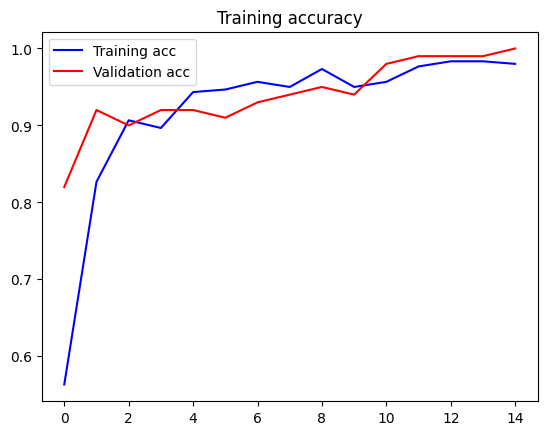

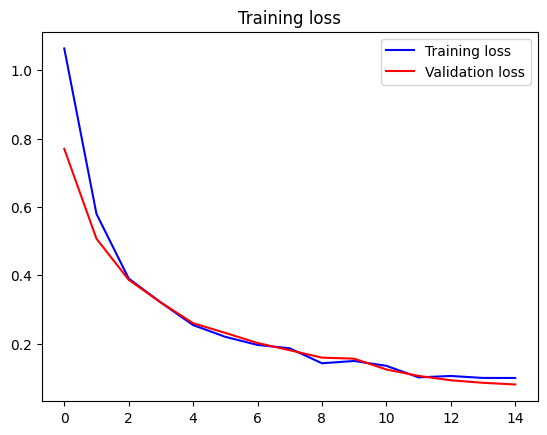

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
 
plt.show()

In [13]:
label_names = ['nothing', 'paper', 'rock', 'scissor']
 
cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))
 
while True:
     
    ret, frame = cap.read()
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    roi = np.array([roi]).astype('float64') / 255.0
  
    pred = model.predict(roi)
     
    target_index = np.argmax(pred[0])
 
    prob = np.max(pred[0])
 
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
     
    cv2.imshow("Rock Paper Scissors", frame)
     
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
 
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 106ms/step


In [14]:
import random

label_names = ['nothing', 'paper', 'rock', 'scissor']

cap = cv2.VideoCapture(0)
box_size = 234
width = int(cap.get(3))

def determine_winner(user_move, computer_move):
    if user_move == computer_move:
        return "Draw"
    elif (user_move == 'rock' and computer_move == 'scissor') or \
         (user_move == 'scissor' and computer_move == 'paper') or \
         (user_move == 'paper' and computer_move == 'rock'):
        return "You win!"
    else:
        return "Computer wins!"

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)

    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)

    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
    
    roi = np.array([roi]).astype('float64') / 255.0

    pred = model.predict(roi)
  
    target_index = np.argmax(pred[0])

 
    prob = np.max(pred[0])

    user_move = label_names[target_index]

  
    computer_move = random.choice(['paper', 'rock', 'scissor'])

    if user_move != 'nothing':
        result = determine_winner(user_move, computer_move)
    else:
        result = "Waiting for your move..."

 
    cv2.putText(frame, "Your move: {} {:.2f}%".format(user_move, prob * 100),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    cv2.putText(frame, "Computer move: {}".format(computer_move),
                (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (255, 0, 0), 2, cv2.LINE_AA)
    cv2.putText(frame, result,
                (10, 120), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow("Rock Paper Scissors", frame)
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 54ms/step
